In [1]:
import matplotlib.pylab as plt
import matplotlib as mpl
mpl.style.use('plotting.mplstyle')
import numpy as np
np.random.seed(15)
import json
import h5py
from read_O3_LVK_results import *
import sys
sys.path.append('./../code/')
from utilities import massModel

In [2]:
# Load AR results
precomputed_data = h5py.File("./../data/ar_chi_cost_summary.hdf","r")
chis = precomputed_data['posterior/chis'][()]
costs = precomputed_data['posterior/costs'][()]
dR_dchis = precomputed_data['posterior/dR_dchis'][()]
dR_dcosts = precomputed_data['posterior/dR_dcosts'][()]
f_chis = precomputed_data['posterior/f_chis'][()]
f_costs = precomputed_data['posterior/f_costs'][()]
R_ref = precomputed_data['posterior/R_ref'][()]
alpha = precomputed_data['posterior/alpha'][()]
mu_m1 = precomputed_data['posterior/mu_m1'][()]
sig_m1 = precomputed_data['posterior/sig_m1'][()]
log_f_peak = precomputed_data['posterior/log_f_peak'][()]
mMin = precomputed_data['posterior/mMin'][()]
mMax = precomputed_data['posterior/mMax'][()]
log_dmMin = precomputed_data['posterior/log_dmMin'][()]
log_dmMax = precomputed_data['posterior/log_dmMax'][()]

## 1. Compute and plot spin magnitude and tilt CDFs

In [3]:
# First construct normalized probability distributions
p_chi = f_chis/np.trapz(f_chis,chis,axis=0)
p_cost = f_costs/np.trapz(f_costs,costs,axis=0)

# Now construct cdfs
cdf_chi = np.cumsum(p_chi*np.diff(np.concatenate([[0],chis]))[:,np.newaxis],axis=0)
cdf_cost = np.cumsum(p_cost*np.diff(np.concatenate([[-1],costs]))[:,np.newaxis],axis=0)

# Extract estimates of 50th and 95th percentiles
chi_50 = np.array([np.interp(0.5,cdf_chi[:,i],chis) for i in range(cdf_chi.shape[1])])
chi_95 = np.array([np.interp(0.95,cdf_chi[:,i],chis) for i in range(cdf_chi.shape[1])])
cost_50 = np.array([np.interp(0.5,cdf_cost[:,i],costs) for i in range(cdf_cost.shape[1])])
cost_95 = np.array([np.interp(0.95,cdf_cost[:,i],costs) for i in range(cdf_cost.shape[1])])

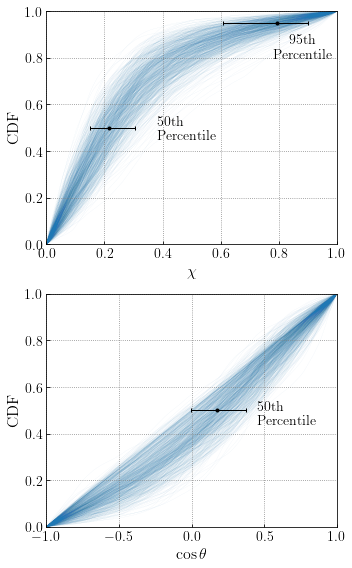

In [4]:
###########################################
# Set up figure to plot spin magnitude CDFs
###########################################

fig = plt.figure(figsize=(5,8))
ax = fig.add_subplot(211)
ax.set_rasterization_zorder(1)

# Loop across a random subset of our posteriors and plot CDFs
nDraws = 750
for i in np.random.choice(range(cdf_chi.shape[1]),size=nDraws,replace=False):
    ax.plot(chis,cdf_chi[:,i],color='#1f78b4',alpha=0.2,lw=0.1,zorder=0)

# Mark 50th and 95th percentiles
ax.errorbar([np.median(chi_50),np.median(chi_95)],
            [0.5,0.95],
            xerr=[[np.median(chi_50)-np.quantile(chi_50,0.05),np.median(chi_95)-np.quantile(chi_95,0.05)],
                  [np.quantile(chi_50,0.95)-np.median(chi_50),np.quantile(chi_95,0.95)-np.median(chi_95)]],
            color='black',
            capsize=2,
            elinewidth=1,
            marker='.',
            linestyle="none")

# Misc formatting
ax.tick_params(labelsize=14)
ax.annotate('50th \n Percentile',xy=(0.38,0.45),fontsize=14,ha='left')
ax.annotate('95th \n Percentile',xy=(0.88,0.8),fontsize=14,ha='center')
ax.set_xlabel(r'$\chi$',fontsize=16)
ax.set_ylabel(r'CDF',fontsize=16)
ax.set_xlim(0,1)
ax.set_ylim(0,1)

###########################################
# Set up figure to plot spin tilt CDFs
###########################################

ax = fig.add_subplot(212)
ax.set_rasterization_zorder(1)

# Loop across a random subset of our posteriors and plot CDFs
nDraws = 750
for i in np.random.choice(range(cdf_cost.shape[1]),size=nDraws,replace=False):
    ax.plot(costs,cdf_cost[:,i],color='#1f78b4',alpha=0.2,lw=0.1,zorder=0)
    
ax.errorbar(np.median(cost_50),
            0.5,
            xerr=[[np.median(cost_50)-np.quantile(cost_50,0.05)],
                  [np.quantile(cost_50,0.95)-np.median(cost_50)]],
            color='black',
            capsize=2,
            elinewidth=1,
            marker='.',
            linestyle="none")

# Misc formatting
ax.tick_params(labelsize=14)
ax.annotate('50th \n Percentile',xy=(0.45,0.44),fontsize=14,ha='left')
ax.set_xlabel(r'$\cos\theta$',fontsize=16)
ax.set_ylabel(r'CDF',fontsize=16)
ax.set_xlim(-1,1)
ax.set_ylim(0,1)

plt.tight_layout()
plt.savefig('figure_09.pdf',bbox_inches='tight',dpi=200)
plt.show()

## 2. Compute rates and probabilities of heavily misaligned spins

In [5]:
# Instantiate arrays to hold total merger rate, rate of mergers with one or more negative cos(tilts),
# and probability of drawing a merger with one or more negative cos(tilts)
nSamples = f_chis.shape[1]
R_tot = np.zeros(nSamples)
R_one_or_both_neg = np.zeros(nSamples)
p_neg = np.zeros(nSamples)

# Loop across posterior samples
# To calculate an overall merger rate, we'll need to also integrate over mass and mass ratio dimensions
for i in range(nSamples):
    
    # Compute variation in the merger rate as a function of primary mass
    m1_grid = np.linspace(2,100.,500)
    f_m1 = massModel(m1_grid,
                     alpha[i],mu_m1[i],sig_m1[i],10.**log_f_peak[i],mMax[i],mMin[i],
                     10.**log_dmMax[i],10.**log_dmMin[i])
    f_m1_norm = massModel(20.,
                     alpha[i],mu_m1[i],sig_m1[i],10.**log_f_peak[i],mMax[i],mMin[i],
                     10.**log_dmMax[i],10.**log_dmMin[i])
    
    # Integrate over masses, in order to obtain a complete merger rate as a function of spin
    int_m1 = np.trapz(f_m1/f_m1_norm,m1_grid)
    
    # Similarly integrate over spin magnitudes and spin tilts
    int_chi = np.trapz(f_chis[:,i],chis)
    int_cost = np.trapz(f_costs[:,i],costs)
    
    # Find fraction of events with one or both spins negative
    # We are using the fact that spins are IID, so that e.g. the fraction of events
    # with two negative spins is the *square* of the fraction of individual spins that are negative
    positive_costheta = costs>0    
    negative_costheta = costs<0
    int_both_neg = np.trapz(f_costs[negative_costheta,i],costs[negative_costheta])**2
    int_one_neg = 2.*np.trapz(f_costs[negative_costheta,i],costs[negative_costheta])*np.trapz(f_costs[positive_costheta,i],costs[positive_costheta])
    int_one_or_both_neg = int_both_neg+int_one_neg
    
    # Compute rate of such events
    # Note again that spin magnitudes are IID, so the magnitude integral factor is squared
    R_one_or_both_neg[i] = R_ref[i]*int_m1*int_chi**2*int_one_or_both_neg
    R_tot[i] = R_ref[i]*int_m1*int_chi**2*int_cost**2
    
    # Probability that individual spins are negative
    p_neg[i] = np.trapz(f_costs[negative_costheta,i],costs[negative_costheta])/int_cost

## 3. Save some of our summary statistics as latex macros

In [6]:
with open('./../macros/component_spin_percentiles.txt','w') as macrofile:
    
    macrofile.write("\\newcommand{{\\SpinMagnitudeFifty}}{{{0:.2f}^{{+{1:.2f}}}_{{-{2:.2f}}}}}".format(\
        np.median(chi_50),
        np.quantile(chi_50,0.95) - np.median(chi_50),
        np.median(chi_50) - np.quantile(chi_50,0.05)))
    macrofile.write("\n")
    
    macrofile.write("\\newcommand{{\\SpinMagnitudeNinetyFive}}{{{0:.2f}^{{+{1:.2f}}}_{{-{2:.2f}}}}}".format(\
        np.median(chi_95),
        np.quantile(chi_95,0.95) - np.median(chi_95),
        np.median(chi_95) - np.quantile(chi_95,0.05)))
    macrofile.write("\n")
    
    macrofile.write("\\newcommand{{\\SpinTiltFifty}}{{{0:.2f}^{{+{1:.2f}}}_{{-{2:.2f}}}}}".format(\
        np.median(cost_50),
        np.quantile(cost_50,0.95) - np.median(cost_50),
        np.median(cost_50) - np.quantile(cost_50,0.05)))
    macrofile.write("\n")
    
    macrofile.write("\\newcommand{{\\SpinTiltMedianPercentPositive}}{{{0:.0f}\\%}}".format(\
        100.*cost_50[cost_50>0].size/cost_50.size))
    macrofile.write("\n")
    
    macrofile.write("\\newcommand{{\\SpinTiltPercentNegative}}{{{0:.0f}^{{+{1:.0f}}}_{{-{2:.0f}}}\\%}}".format(\
        100.*np.median(p_neg),
        100.*np.quantile(p_neg,0.95) - 100.*np.median(p_neg),
        100.*np.median(p_neg) - 100.*np.quantile(p_neg,0.05)))
    macrofile.write("\n")
    
    macrofile.write("\\newcommand{{\\SpinTiltRateOneOrBothNegative}}{{{0:.1f}^{{+{1:.1f}}}_{{-{2:.1f}}}}}".format(\
        np.median(R_one_or_both_neg),
        np.quantile(R_one_or_both_neg,0.95) - np.median(R_one_or_both_neg),
        np.median(R_one_or_both_neg) - np.quantile(R_one_or_both_neg,0.05)))
    macrofile.write("\n")
    